In [67]:
#Loading libraries
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
df=pd.read_csv('ac_march_merged.csv')
df=df.iloc[:,0:2]
df=df.set_index('Date')
df.index = pd.to_datetime(df.index)
#df = df.resample('D').ffill()
df=df.transpose()
df.head()

Date,2017-11-14 00:00:00,2017-11-15 00:00:00,2017-11-16 00:00:00,2017-11-17 00:00:00,2017-11-20 00:00:00,2017-11-21 00:00:00,2017-11-22 00:00:00,2017-11-24 00:00:00,2017-11-27 00:00:00,2017-11-28 00:00:00,...,2019-08-19 00:00:00,2019-08-20 00:00:00,2019-08-21 00:00:00,2019-08-22 00:00:00,2019-08-23 00:00:00,2019-08-26 00:00:00,2019-08-27 00:00:00,2019-08-28 00:00:00,2019-08-29 00:00:00,2019-08-30 00:00:00
Close,978.5,985.0,983.0,996.5,998.5,998.0,1003.0,1000.5,1001.75,1001.75,...,893.75,895.25,900.25,895.5,885.25,893.5,886.25,892.0,894.0,894.25


In [69]:
data_start_date = df.columns[0]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2017-11-14 00:00:00 to 2019-08-30 00:00:00


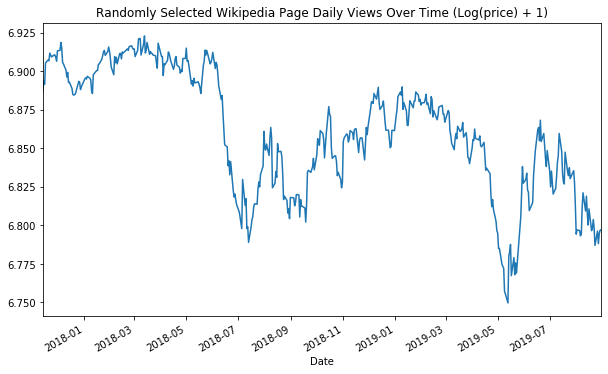

In [70]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    #page_labels = sample['Date'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(price) + 1)')
    #plt.legend(page_labels)
    
plot_random_series(df, 1)

## Train and Validation Series Partioning

In [48]:
from datetime import timedelta

pred_steps = 5
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [49]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [50]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2017-11-14 00:00:00 - 2019-08-20 00:00:00
Train prediction: 2019-08-21 00:00:00 - 2019-08-25 00:00:00 

Val encoding: 2017-11-19 00:00:00 - 2019-08-25 00:00:00
Val prediction: 2019-08-26 00:00:00 - 2019-08-30 00:00:00

Encoding interval: 645
Prediction interval: 5


In [51]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

## Model building

In [52]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 10 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim,return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [53]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 10), (None,  480         input_9[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, None, 10), ( 480         input_10[0][0]                   
                                                                 lstm_7[0][1]               

In [54]:
first_n_samples = 100000
batch_size = 1
epochs = 500

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0)

Epoch 1/500
1/1 [==============================] - 1s 550ms/step - loss: 0.0597
Epoch 2/500
1/1 [==============================] - 0s 88ms/step - loss: 0.0551
Epoch 3/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0505
Epoch 4/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0459
Epoch 5/500
1/1 [==============================] - 0s 80ms/step - loss: 0.0413
Epoch 6/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0367
Epoch 7/500
1/1 [==============================] - 0s 80ms/step - loss: 0.0320
Epoch 8/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0272
Epoch 9/500
1/1 [==============================] - 0s 82ms/step - loss: 0.0223
Epoch 10/500
1/1 [==============================] - 0s 83ms/step - loss: 0.0174
Epoch 11/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0124
Epoch 12/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0102
Epoch 13/500
1/1 [==============================

Epoch 104/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0014
Epoch 105/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0015
Epoch 106/500
1/1 [==============================] - 0s 75ms/step - loss: 0.0015
Epoch 107/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0016
Epoch 108/500
1/1 [==============================] - 0s 78ms/step - loss: 0.0016
Epoch 109/500
1/1 [==============================] - 0s 84ms/step - loss: 0.0015
Epoch 110/500
1/1 [==============================] - 0s 76ms/step - loss: 0.0015
Epoch 111/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0015
Epoch 112/500
1/1 [==============================] - 0s 80ms/step - loss: 0.0016
Epoch 113/500
1/1 [==============================] - 0s 86ms/step - loss: 0.0014
Epoch 114/500
1/1 [==============================] - 0s 79ms/step - loss: 0.0016
Epoch 115/500
1/1 [==============================] - 0s 75ms/step - loss: 0.0017
Epoch 116/500
1/1 [=========

1/1 [==============================] - 0s 91ms/step - loss: 0.0013
Epoch 206/500
1/1 [==============================] - 0s 89ms/step - loss: 0.0014
Epoch 207/500
1/1 [==============================] - 0s 86ms/step - loss: 0.0014
Epoch 208/500
1/1 [==============================] - 0s 92ms/step - loss: 0.0013
Epoch 209/500
1/1 [==============================] - 0s 90ms/step - loss: 0.0014
Epoch 210/500
1/1 [==============================] - 0s 86ms/step - loss: 0.0014
Epoch 211/500
1/1 [==============================] - 0s 93ms/step - loss: 0.0013
Epoch 212/500
1/1 [==============================] - 0s 90ms/step - loss: 0.0013
Epoch 213/500
1/1 [==============================] - 0s 89ms/step - loss: 0.0013
Epoch 214/500
1/1 [==============================] - 0s 92ms/step - loss: 0.0013
Epoch 215/500
1/1 [==============================] - 0s 89ms/step - loss: 0.0013
Epoch 216/500
1/1 [==============================] - 0s 89ms/step - loss: 0.0014
Epoch 217/500
1/1 [=======================

Epoch 306/500
1/1 [==============================] - 0s 89ms/step - loss: 9.8072e-04
Epoch 307/500
1/1 [==============================] - 0s 89ms/step - loss: 9.4396e-04
Epoch 308/500
1/1 [==============================] - 0s 87ms/step - loss: 9.7859e-04
Epoch 309/500
1/1 [==============================] - 0s 95ms/step - loss: 8.9984e-04
Epoch 310/500
1/1 [==============================] - 0s 86ms/step - loss: 9.2396e-04
Epoch 311/500
1/1 [==============================] - 0s 90ms/step - loss: 8.8098e-04
Epoch 312/500
1/1 [==============================] - 0s 96ms/step - loss: 9.1749e-04
Epoch 313/500
1/1 [==============================] - 0s 82ms/step - loss: 8.4022e-04
Epoch 314/500
1/1 [==============================] - 0s 86ms/step - loss: 0.0010
Epoch 315/500
1/1 [==============================] - 0s 89ms/step - loss: 8.2407e-04
Epoch 316/500
1/1 [==============================] - 0s 86ms/step - loss: 8.6181e-04
Epoch 317/500
1/1 [==============================] - 0s 84ms/step - l

Epoch 404/500
1/1 [==============================] - 0s 89ms/step - loss: 3.9511e-04
Epoch 405/500
1/1 [==============================] - 0s 90ms/step - loss: 7.0489e-04
Epoch 406/500
1/1 [==============================] - 0s 90ms/step - loss: 5.0703e-04
Epoch 407/500
1/1 [==============================] - 0s 91ms/step - loss: 3.1365e-04
Epoch 408/500
1/1 [==============================] - 0s 87ms/step - loss: 5.8358e-04
Epoch 409/500
1/1 [==============================] - 0s 88ms/step - loss: 4.2293e-04
Epoch 410/500
1/1 [==============================] - 0s 87ms/step - loss: 5.2785e-04
Epoch 411/500
1/1 [==============================] - 0s 87ms/step - loss: 5.0533e-04
Epoch 412/500
1/1 [==============================] - 0s 90ms/step - loss: 5.0454e-04
Epoch 413/500
1/1 [==============================] - 0s 90ms/step - loss: 4.5562e-04
Epoch 414/500
1/1 [==============================] - 0s 90ms/step - loss: 5.7874e-04
Epoch 415/500
1/1 [==============================] - 0s 87ms/step

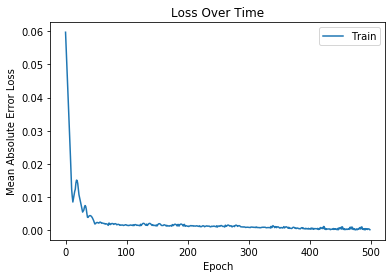

In [56]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [57]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [58]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [59]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data.reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series

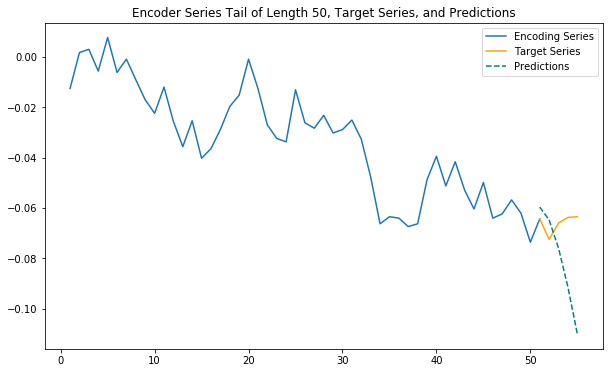

In [60]:
pred_series = predict_and_plot(encoder_input_data, decoder_target_data, 100, enc_tail_len=50)

In [85]:
a = transform_series_decode(pred_series, encode_series_mean)

In [86]:
a = -a

In [87]:
a

array([[[6.92212391]],

       [[6.92759264]],

       [[6.9396248 ]],

       [[6.95648254]],

       [[6.97714249]]])

In [90]:
np.expm1(a)

array([[[1013.47235474]],

       [[1019.03542691]],

       [[1031.38279273]],

       [[1048.93395449]],

       [[1070.85116127]]])

In [88]:
b = list(df.iloc[0,-5:])

In [89]:
b

[893.5, 886.25, 892.0, 894.0, 894.25]